## Imports

In [ ]:
# from google.colab import files
# ! pip install -q kaggle
# files.upload()
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle datasets download -d snap/amazon-fine-food-reviews
# ! unzip /content/amazon-fine-food-reviews.zip -d "/content/drive/MyDrive/Colab Notebooks/NLP/AmazonFineFoodReviews/amazon-fine-food-reviews"?

In [75]:
import os
import re
import time
import string
from tqdm import tqdm
from itertools import groupby
from bs4 import BeautifulSoup

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [78]:
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [79]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [80]:
!pip install contractions
!pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
import swifter
import contractions

In [82]:
import warnings
warnings.filterwarnings('ignore')

## Data Read

In [83]:
# Read in train and test data.
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/AmazonFineFoodReviews/amazon-fine-food-reviews/Reviews.csv')


In [84]:
train_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [85]:
train_df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


## Data Cleaning

### Filter Review as Positive and Negative

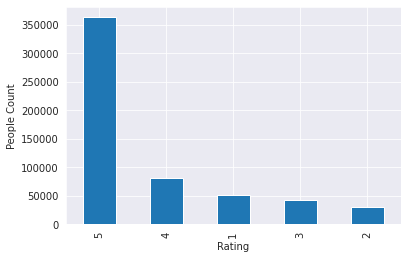

In [86]:
train_df['Score'].value_counts().plot(kind='bar')
plt.xlabel("Rating")
plt.ylabel("People Count")
plt.show()

We can see that we have 5-star rating system. We can filter onlt positive and negitive reviews. 

- Review with score>3 : Positive ratings
- Review with score<3 : Negative ratings
- Review with score=3 : Neutral rating (we can skip those ratings)

In [87]:
filtered_data = train_df[train_df['Score'] != 3]
filtered_data.loc[train_df.Score >3,'Score'] = 1    # Positive review
filtered_data.loc[train_df.Score <3,'Score'] = 0    # Negative review

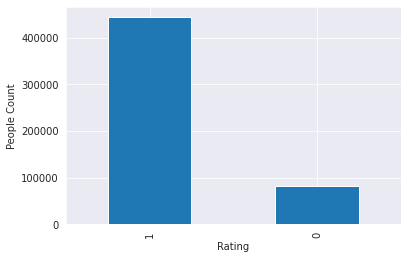

In [88]:
filtered_data['Score'].value_counts().plot(kind='bar')
plt.xlabel("Rating")
plt.ylabel("People Count")
plt.show()

### Checking duplicates
Reviews might contain duplicate entries.  So, we need to remove the duplicate entries so that we get unbiased data for Analysis.

Check duplicate customers with same Summary and Text.

In [89]:
filtered_data.shape

(525814, 10)

In [90]:
# filtered_data.duplicated(subset=["UserId","ProfileName","Time","Summary","Text"]).value_counts()
# filtered_data.duplicated(subset=["Time","Summary","Text"]).value_counts()
filtered_data.duplicated(subset=["UserId", "Summary", "Text", "Time"]).value_counts()

False    365293
True     160521
dtype: int64

As we can see that we have 160678 duplicate customers with same Summary and Text.

Let's remove those customers. Sort the data according to ProductId and keep the first items review and delete the others.

In [91]:

# Sort according to ProductId
sorted_data = filtered_data.sort_values(
    by=["ProductId"], axis=0, ascending=True, inplace=False, kind='mergesort', na_position='last'
)

# drop duplicated data
final = sorted_data.drop_duplicates(subset={"UserId", "Summary", "Text", "Time"}, keep='first', inplace=False)
final.shape

(365293, 10)

`HelpfulnessNumerator` : Number of users who found the review helpful.

`HelpfulnessDenominator` : Number of users who indicated whether they found the review helpful or not.

**HelpfulnessNumerator should be less than HelpfulnessDenominator.**

In [92]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.shape

(365291, 10)

In [93]:
final['Text'].loc[374304]

'Beetlejuice <a href="http://www.amazon.com/gp/product/B001AGXEA6">Beetlejuice [Blu-ray</a>] is a timeless classic with Michael Keaton providing an excellent performance.  The afterlife concept of the film is excellent as well as entertaining; this film is a must for your video library... It\'s to be watched over and over again.<br /><br />The casting for this film is perfect, Michael Keaton is the outrageously funny and whacky witted (Betelguese - the afterlife\'s leading freelance bio-exorcist) with Alec Baldwin and Geena Davis playing (Adam and Barbara Maitland), a young couple that die prematurely. Adding to the cast are Jeffrey Jones and Catherine O\'Hara (as Charles and Delia Deetz, and their Goth daughter Winona Ryder (as Lydia).<br /><br />One of the most hilarious scenes is the dinner party accompanied by Harry Belafonte\'s Banana Boat song `Day-O\'.  This is truly Tim Burton at his finest taking the significance of being dead and dousing it with humor.'

In [94]:
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150492,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,1,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
150493,150494,0006641040,AYZ0PR5QZROD1,Mother of 3 girls,3,3,1,1173312000,Family favorite,All of my children love this book. My first g...
150495,150496,0006641040,A3KKR87BJ0C595,"Gretchen Goodfellow ""Lover of children's lit""",3,3,1,1111363200,"You'll use it once, you'll use it twice",One of my earliest memories is of this book. ...
150496,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,0,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....
150497,150498,0006641040,A3SJWISOCP31TR,R. J. Wells,2,2,1,1176336000,A Gem of a Book,This is a wonderful little book. I loved it 40...


### Checking null values.

In [95]:
# check for null values
final.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    1
Text                       0
dtype: int64

No null values are present

## Text Processing

In [96]:
STOPWORDS = nltk.corpus.stopwords.words('english')
print(STOPWORDS)

STOPWORDS =  [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it',  "it's", 'its', 
    'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',  'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',  'or', 'because', 'as', 'until', 'while', 'of', 'at',  'for', 'with',
    'about', 'between', 'into',  'through', 'during',  'to',  'from', 
    'in', 'out', 'on', 'off',  'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
    'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few',  'other', 'some', 'such', 'only', 'own', 
    'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 
    'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',  "didn't", 'doesn', 
    "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', 
    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
    'won', "won't", 'wouldn', "wouldn't", "would", "could"
]


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [97]:
class TextProcess:

  def __init__(self, df, stopwords=[]):
    self.df = df
    self.stopwords = stopwords

  def decontracted(self, text):
      '''
      Function to expand the shotened words: what've ---> what have
      '''
      expanded_words = []    
      for word in text.split():
        # using contractions.fix to expand the shotened words
        expanded_words.append(contractions.fix(word))   

      expanded_text = ' '.join(expanded_words)
      return expanded_text

  def remove_stopwords(self, text):
      text = text.strip().split()
      text = [word for word in text if word not in self.stopwords and len(word)>1]
      return ' '.join(text)

  def remove_html_tags(self, text):
      '''Remove html tags'''
      return BeautifulSoup(text, 'lxml').get_text()

  def remove_consecutive_duplicate(self, text):
      '''Remove consecutive duplicate'''
      text = text.split()
      text = [i[0] for i in groupby(text)]
      return " ".join(text)

  def remove_space(self, text):
      # text = re.sub('[^\w\s]', ' ', text)   # remove punc
      text = re.sub("[\s]+", ' ', text)
      return text

  def remove_punc(self, text):
      # text = re.sub('[^\w\s]', ' ', text)   # remove punc
      text = [word for word in text.split() if word not in string.punctuation]
      text = " ".join(text)
      text = re.sub("[\s]+", ' ', text)
      return text

  def nltk_tag_to_wordnet_tag(self, nltk_tag):
      if nltk_tag.startswith('J'):
          return wordnet.ADJ
      elif nltk_tag.startswith('V'):
          return wordnet.VERB
      elif nltk_tag.startswith('N'):
          return wordnet.NOUN
      elif nltk_tag.startswith('R'):
          return wordnet.ADV
      else:
          return None

  def lemmatize_sentence(self, sentence):
      lemmatizer = WordNetLemmatizer()
      #tokenize the sentence and find the POS tag for each token
      nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))

      #tuple of (token, wordnet_tag)
      wordnet_tagged = map(lambda x: (x[0], self.nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)

      lemmatized_sentence = []
      for word, tag in wordnet_tagged:
          if tag is None:
              #if there is no available tag, append the token as is
              lemmatized_sentence.append(word)
          else:
              #else use the tag to lemmatize the token
              lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))

      return self.remove_stopwords(" ".join(lemmatized_sentence))

  def lemma_spacy(self, sentence):
      try:
        import spacy
        NLP_OBJ = spacy.load("en_core_web_sm", disable=['ner'])
        doc = NLP_OBJ(sentence)
        sentence = " ".join([token.lemma_ for token in doc])
        return sentence
      except:
        return sentence

  def text_process_df(self):
    print("Start cleaning dataframe...")
    self.df['clean_review'] = self.df['Text'].swifter.apply(self.clean_text)
    # print("Start lemmatize dataframe..")
    # self.df['clean_review'] = self.df['clean_review'].swifter.apply(self.lemmatize_sentence)
    # self.df['clean_review'] = self.df['clean_review'].swifter.apply(self.lemma_spacy)
    return self.df

  def token(self, text):
    text = nltk.word_tokenize(text)
    return " ".join(text)

  def clean_text(self, sentence):
    '''
    Function to clean the text and remove all the unnecessary elements.
    '''
    sentence = sentence.lower()                     # make the text lowercase
    sentence = self.remove_html_tags(sentence)
    sentence = self.token(sentence)
    sentence = self.decontracted(sentence)          # expand the shotened words   what've ---> what have
    sentence = self.remove_punc(sentence)
    sentence = self.remove_space(sentence)
    sentence = self.remove_consecutive_duplicate(sentence)
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = self.remove_stopwords(sentence)
    sentence = self.lemmatize_sentence(sentence)
    return sentence


In [98]:
text_process_obj = TextProcess(df=final, stopwords=STOPWORDS)

In [99]:
a = '''Beetlejuice <a href="http://www.amazon.com/gp/product/B001AGXEA6">Beetlejuice [Blu-ray</a>] is a timeless classic with Michael Keaton providing an excellent performance.  The afterlife concept of the film is excellent as well as entertaining; this film is a must for your video library... It's to be watched over and over again.<br /><br />The casting for this film is perfect, Michael Keaton is the outrageously funny and whacky witted (Betelguese - the afterlife's leading freelance bio-exorcist) with Alec Baldwin and Geena Davis playing (Adam and Barbara Maitland), a young couple that die prematurely. Adding to the cast are Jeffrey Jones and Catherine O'Hara (as Charles and Delia Deetz, and their Goth daughter Winona Ryder (as Lydia).<br /><br />One of the most hilarious scenes is the dinner party accompanied by Harry Belafonte's Banana Boat song `Day-O'.  This is truly Tim Burton at his finest taking the significance of being dead and dousing it with humor.'''

In [100]:
text_process_obj.clean_text(a)

'beetlejuice blu ray timeless classic michael keaton provide excellent performance afterlife concept film excellent well entertaining film must video library watch casting film perfect michael keaton outrageously funny whacky witted betelguese afterlife lead freelance bio exorcist alec baldwin geena davis play adam barbara maitland young couple die prematurely add cast jeffrey jones catherine hara charles delia deetz goth daughter winona ryder lydia one most hilarious scene dinner party accompany by harry belafonte banana boat song day truly tim burton fine take significance dead dousing humor'

In [110]:
final = text_process_obj.text_process_df()

Start cleaning dataframe...


Pandas Apply:   0%|          | 0/365291 [00:00<?, ?it/s]

In [111]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_review
150492,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,1,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""...",day person say chicken soup probably go follow...
150493,150494,0006641040,AYZ0PR5QZROD1,Mother of 3 girls,3,3,1,1173312000,Family favorite,All of my children love this book. My first g...,child love book first grader get christmas lov...
150495,150496,0006641040,A3KKR87BJ0C595,"Gretchen Goodfellow ""Lover of children's lit""",3,3,1,1111363200,"You'll use it once, you'll use it twice",One of my earliest memories is of this book. ...,one early memory book mother read us constantl...
150496,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,0,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....,give five star maurice sendak story one star p...
150497,150498,0006641040,A3SJWISOCP31TR,R. J. Wells,2,2,1,1176336000,A Gem of a Book,This is a wonderful little book. I loved it 40...,wonderful little book love year ago twin love ...


In [113]:
pth = "/content/drive/MyDrive/Colab Notebooks/NLP/AmazonFineFoodReviews/amazon-fine-food-reviews/final_clean.csv"
final.to_csv(pth)

In [114]:
# dd = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/AmazonFineFoodReviews/amazon-fine-food-reviews/final_clean.csv")

In [116]:
# dd.head()

## EDA

In [117]:
class EDA:
  def __init__(self, df, col):
    self.df = df
    self.col = col
    # col = 'clean_review'
    self.word_freq = self.df[col].apply(self.check_word_frequency)
    self.WORDS = self.get_all_words()

  def get_all_words(self):
    WORDS = self.df[self.col].str.split().values.tolist()
    WORDS = [w for seq in WORDS for w in seq]    # list of all words from corpus
    return WORDS

  def check_word_frequency(self, text):
      return len(str(text).split(' '))

  def plot_word_counts(self):
      sns.set_style('darkgrid')
      fig = plt.figure(figsize=(10,5))

      plt.hist(self.word_freq, bins=40, color='#30105C')
      
      plt.title('Distribution - Word Frequency', fontsize=16)
      plt.xlabel('Word Frequncy', fontsize=12)
      plt.ylabel('Frequency', fontsize=12)
      plt.show()

  def find_ngram(self, word, n):
      word_fd = nltk.FreqDist(word)
      n_gram_fd = nltk.FreqDist(nltk.ngrams(word, n))
      return word_fd, n_gram_fd

  def ngram_plot(self, n):
    unigram_word_fd, unigram = self.find_ngram(self.WORDS, n)
    pd.DataFrame(unigram.most_common(30), columns = ['word', 'count']).plot.barh(x = 'word', figsize=(10, 12))
    plt.show()
    # print(unigram.most_common(20))


In [118]:
col = 'clean_review'
eda_obj = EDA(final, col)

### Distribution - Word Frequency

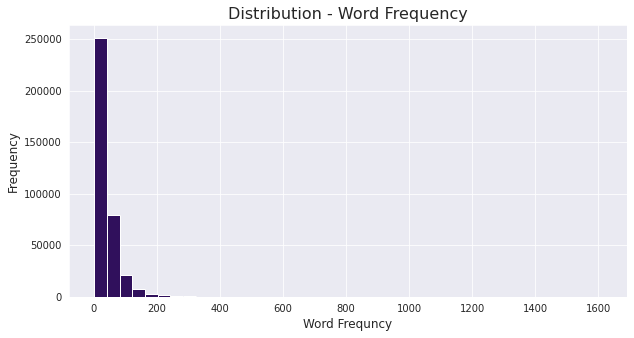

In [119]:
eda_obj.plot_word_counts()

### Plot for unigram

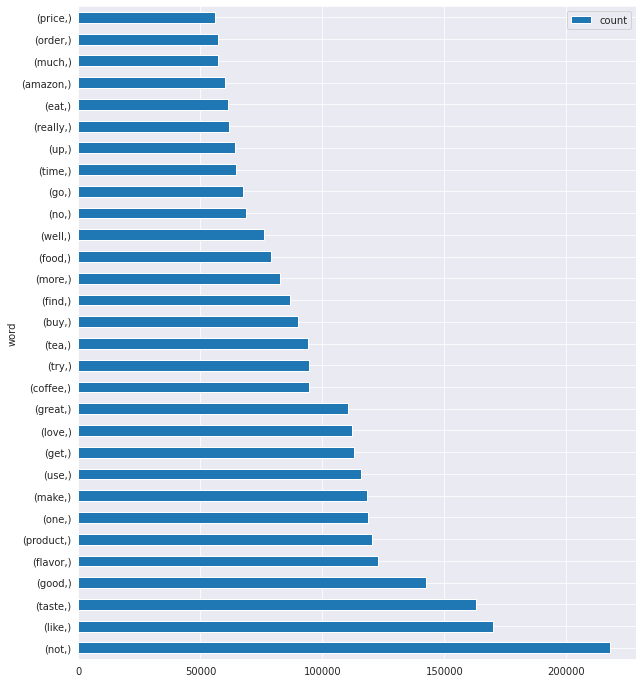

In [120]:
eda_obj.ngram_plot(1)

### Plot for bigram

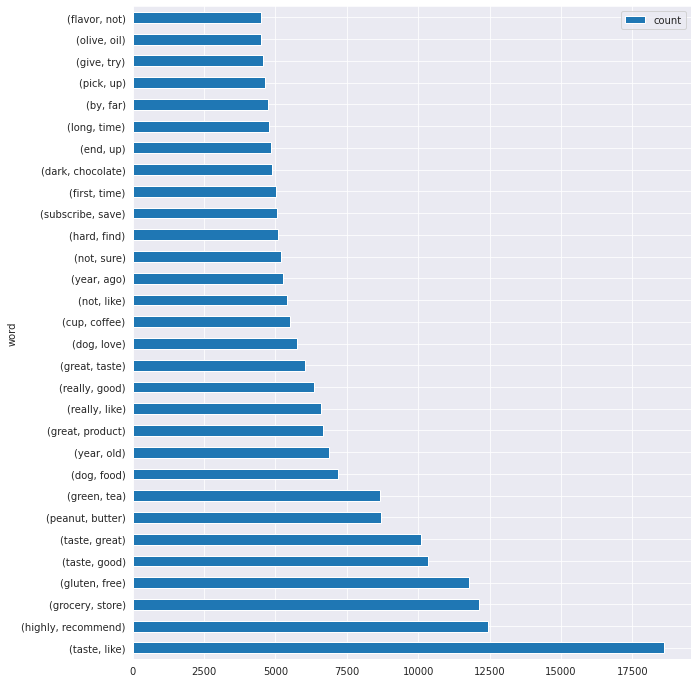

In [121]:
eda_obj.ngram_plot(2)

### Plot for trigram

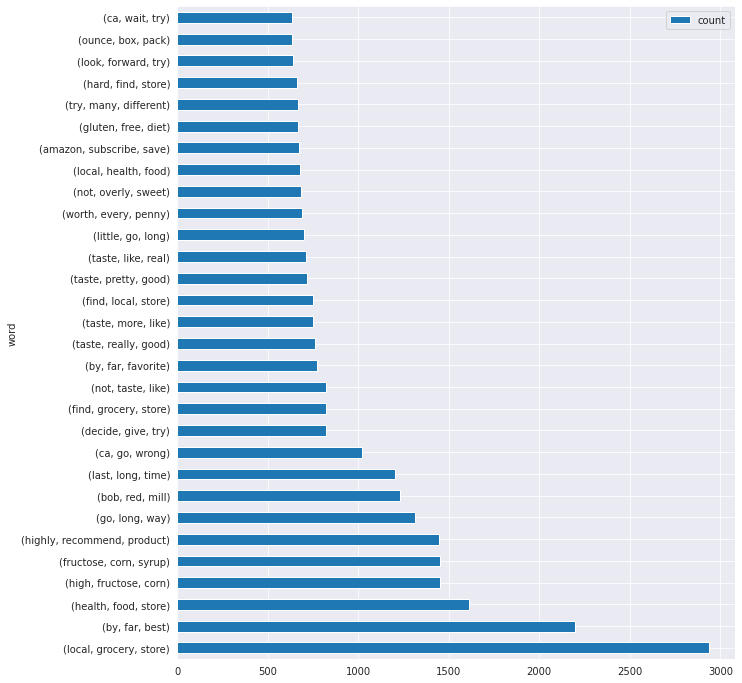

In [122]:
eda_obj.ngram_plot(3)

In [123]:
from imblearn.over_sampling import SMOTE
from imblearn import over_sampling

## Splitting the data into train & test data

In [124]:
class Feature:
  def __init__(self, X, y):
    # self.df = df
    self.X = X
    self.y = y
    self.random_state = 42

    self.word_vectorizer, self.vectorized_df = self.vectorizer_def(self.X)
    self.X_train, self.X_test, self.y_train, self.y_test = self.split_data(X, y)
    # self.X_train_transformed, self.X_test_transformed = transform_x_data(self.X_train, self.X_test)

  def vectorizer_def(self, X):
    word_vectorizer = TfidfVectorizer(
        strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step. 
        analyzer='word',            # Whether the feature should be made of word or character n-grams.
        token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'
        ngram_range=(1, 2),         # The lower and upper boundary of the range of n-values for different n-grams to be extracted
        stop_words='english',
        min_df=40,
        max_features=7000,
        sublinear_tf=True)

    word_vectorizer.fit(X)    # Fiting it on Train
    vectorized_df = word_vectorizer.transform(X)
    return word_vectorizer, vectorized_df

  def transform_x_data(self, X_train, X_test):
      ## transforming the train and test datasets
      X_train_transformed = self.word_vectorizer.transform(X_train.tolist())
      X_test_transformed = self.word_vectorizer.transform(X_test.tolist())
      return X_train_transformed, X_test_transformed

  def ros_sample(self, x, y):
    ros = RandomOverSampler(random_state=self.random_state)
    X_ROS, y_ROS = ros.fit_resample(x, y)
    # X_train, x_test, Y_train, y_test = self.split_data(X_ROS, y_ROS)
    return X_ROS, y_ROS

  def smote_sample(self, x, y):
    ros = SMOTE(random_state=self.random_state)
    X_smote, y_smote = ros.fit_resample(x, y)
    # X_train, x_test, Y_train, y_test = self.split_data(X_smote, y_smote)
    return X_smote, y_smote

  def split_data(self, x, y):
    X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=self.random_state)
    return X_train, X_test, y_train, y_test


In [125]:
x = final['clean_review'] 
y = final['Score']


def print_shape(X_train_, X_test_, y_train_, y_test_):
  print("X_train shape:", X_train_.shape)
  print("y_train shape:", y_train_.shape)
  print("--"*20)
  print("X_test shape:", X_test_.shape)
  print("y_test shape:", y_test_.shape)

In [126]:
feature_obj = Feature(x, y)

In [127]:
X_train_, X_test_, y_train, y_test = feature_obj.X_train, feature_obj.X_test, feature_obj.y_train, feature_obj.y_test

In [128]:
print_shape(X_train_, X_test_, y_train, y_test)

X_train shape: (292232,)
y_train shape: (292232,)
----------------------------------------
X_test shape: (73059,)
y_test shape: (73059,)


### TF-IDF

In [129]:
X_train, X_test = feature_obj.transform_x_data(X_train_, X_test_)
print_shape(X_train, X_test, y_train, y_test)

X_train shape: (292232, 7000)
y_train shape: (292232,)
----------------------------------------
X_test shape: (73059, 7000)
y_test shape: (73059,)


### ROS

In [130]:
# # X_train_ros, X_test_ros, y_train_ros, y_test_ros = feature_obj.ros_sample(feature_obj.vectorized_df, y)
# X_train_ros, y_train_ros = feature_obj.ros_sample(X_train, y_train)
# X_test_ros, y_test_ros = X_test, y_test

In [131]:
# print_shape(X_train_ros, X_test_ros, y_train_ros, y_test_ros)

### SMOTE

In [132]:
# # X_train_smote, X_test_smote, y_train_smote, y_test_smote = feature_obj.smote_sample(feature_obj.vectorized_df, y)
# X_train_smote, y_train_smote = feature_obj.smote_sample(X_train, y_train)
# X_test_smote, y_test_smote = X_test, y_test

In [133]:
# print_shape(X_train_smote, X_test_smote, y_train_smote, y_test_smote)

## Model

In [134]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def pred_score(model, x_, y_, plot=True):
  # Prediction Train Data
  y_pred = model.predict(x_)
  #Model Performance on Train Dataset
  print("Accuracy", accuracy_score(y_pred, y_))
  print(classification_report(y_pred, y_))
  if plot:
    plot_confusion_matrix(model, x_, y_)

def plot_confusion_matrix(model, X_test_, y_test_):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['1', '2', '3', '4', '5']
    # use model to do the prediction
    y_pred = model.predict(X_test_)
    # compute confusion matrix
    cm = confusion_matrix(y_test_, y_pred, labels=model.classes_)
    # plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.grid(False)
    plt.show()
    # sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
    #             xticklabels=sentiment_classes,
    #             yticklabels=sentiment_classes)
    # plt.title('Confusion matrix', fontsize=16)
    # plt.ylabel('Actual label', fontsize=12)
    # plt.xlabel('Predicted label', fontsize=12)

### Logistic Regression

#### Logistic Regression

In [135]:
time1 = time.time()

lr = LogisticRegression()
lr = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=123)
lr.fit(X_train, y_train)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 7.03 seconds


In [136]:
pred_score(lr, X_train, y_train, plot=False)

Accuracy 0.8979543650250486
              precision    recall  f1-score   support

           0       0.90      0.62      0.74     66746
           1       0.90      0.98      0.94    225486

    accuracy                           0.90    292232
   macro avg       0.90      0.80      0.84    292232
weighted avg       0.90      0.90      0.89    292232



Accuracy 0.892128279883382
              precision    recall  f1-score   support

           0       0.88      0.61      0.72     16527
           1       0.89      0.98      0.93     56532

    accuracy                           0.89     73059
   macro avg       0.89      0.79      0.83     73059
weighted avg       0.89      0.89      0.88     73059



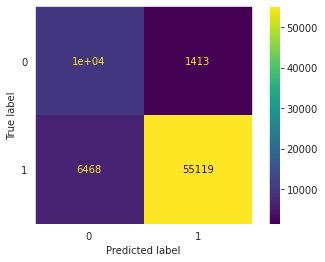

In [137]:
pred_score(lr, X_test, y_test)

### Random Forest

#### Random Forest

In [ ]:
time1 = time.time()

rf = RandomForestClassifier(max_depth=15, random_state=50, n_jobs=-1)
# rf = RandomForestClassifier(n_estimators=500, max_depth=100, min_samples_leaf=4, min_samples_split=8, random_state=50, n_jobs=-1)
rf.fit(X_train, y_train)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 41.42 seconds


In [ ]:
pred_score(rf, X_train, y_train, plot=False)

Accuracy 0.8444865723124093
              precision    recall  f1-score   support

           0       0.01      1.00      0.02       441
           1       1.00      0.84      0.92    291791

    accuracy                           0.84    292232
   macro avg       0.50      0.92      0.47    292232
weighted avg       1.00      0.84      0.91    292232



Accuracy 0.8440712301016986
              precision    recall  f1-score   support

           0       0.01      0.99      0.01        82
           1       1.00      0.84      0.92     72977

    accuracy                           0.84     73059
   macro avg       0.50      0.92      0.46     73059
weighted avg       1.00      0.84      0.91     73059



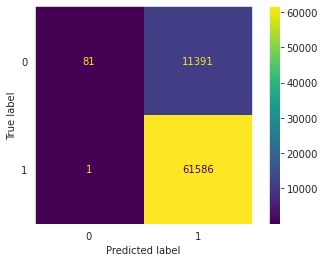

In [ ]:
pred_score(rf, X_test, y_test)

### MultinomialNB

In [138]:
time1 = time.time()
from sklearn.naive_bayes import BernoulliNB

nb_ros = MultinomialNB(alpha=0.00005)
# nb_ros = BernoulliNB(alpha=0.1)
nb_ros.fit(X_train, y_train)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 0.10 seconds


In [139]:
pred_score(nb_ros, X_train, y_train, plot=False)

Accuracy 0.8927153768238933
              precision    recall  f1-score   support

           0       0.36      0.89      0.51     18675
           1       0.99      0.89      0.94    273557

    accuracy                           0.89    292232
   macro avg       0.68      0.89      0.73    292232
weighted avg       0.95      0.89      0.91    292232



Accuracy 0.8913617760987695
              precision    recall  f1-score   support

           0       0.35      0.89      0.50      4517
           1       0.99      0.89      0.94     68542

    accuracy                           0.89     73059
   macro avg       0.67      0.89      0.72     73059
weighted avg       0.95      0.89      0.91     73059



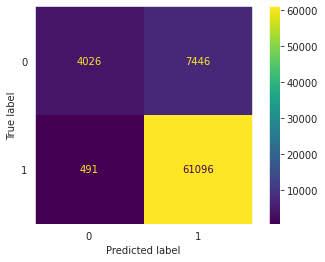

In [140]:
pred_score(nb_ros, X_test, y_test)

## Hyperparameter Tuning

In [141]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)

def grid_search_csv(dict_params):
    # GridSearchCV
    model_lr_final = GridSearchCV(estimator=dict_params['model'], param_grid=dict_params['params'],
                                  cv=skf, scoring='f1_macro', n_jobs = -1, verbose=1)
    # fit cv
    model_lr_final = model_lr_final.fit(dict_params['X_train'], dict_params['y_train'])
    # best_estimator
    best_estimator = model_lr_final.best_estimator_
    best_params = model_lr_final.best_params_
    print("Best parameters", best_params)
    
    return best_estimator, best_params

#### Logistic Regression

In [142]:
lr_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=123)

params = {'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 7]}
dict_params = {'model':lr_model, 'params': params, 'X_train':X_train, 'y_train':y_train}

In [143]:
lr_model_tf, best_params = grid_search_csv(dict_params)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters {'C': 2, 'penalty': 'l2'}


In [144]:
pred_score(lr_model_tf, X_train, y_train, plot=False)

Accuracy 0.8993197185797586
              precision    recall  f1-score   support

           0       0.91      0.62      0.74     66607
           1       0.90      0.98      0.94    225625

    accuracy                           0.90    292232
   macro avg       0.90      0.80      0.84    292232
weighted avg       0.90      0.90      0.89    292232



Accuracy 0.8924430939377763
              precision    recall  f1-score   support

           0       0.88      0.61      0.72     16480
           1       0.90      0.97      0.93     56579

    accuracy                           0.89     73059
   macro avg       0.89      0.79      0.83     73059
weighted avg       0.89      0.89      0.89     73059



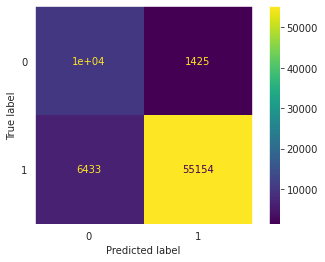

In [145]:
pred_score(lr_model_tf, X_test, y_test)

### MultinomialNB

In [146]:
nb_model = MultinomialNB()
params = {'alpha': (0.00005, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)}
dict_params = {'model':nb_model, 'params': params, 'X_train':X_train, 'y_train':y_train}

In [147]:
nb_model_tf, best_params = grid_search_csv(dict_params)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters {'alpha': 5e-05}


In [148]:
# pred_score(lr_model_tf, X_train_ros, y_train_ros, plot=False)
pred_score(nb_model_tf, X_train, y_train, plot=False)

Accuracy 0.8927153768238933
              precision    recall  f1-score   support

           0       0.36      0.89      0.51     18675
           1       0.99      0.89      0.94    273557

    accuracy                           0.89    292232
   macro avg       0.68      0.89      0.73    292232
weighted avg       0.95      0.89      0.91    292232



Accuracy 0.8913617760987695
              precision    recall  f1-score   support

           0       0.35      0.89      0.50      4517
           1       0.99      0.89      0.94     68542

    accuracy                           0.89     73059
   macro avg       0.67      0.89      0.72     73059
weighted avg       0.95      0.89      0.91     73059



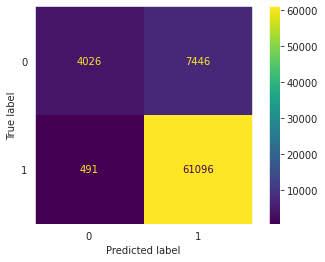

In [149]:
# pred_score(lr_model_tf, X_test_ros, y_test_ros)
pred_score(nb_model_tf, X_test, y_test)

## Save Model

In [67]:
import pickle

In [150]:
pth = '/content/drive/MyDrive/Colab Notebooks/NLP/AmazonFineFoodReviews/amazon-fine-food-reviews'

pickle.dump(lr, open(os.path.join(pth,'model.pkl'), 'wb'))
pickle.dump(feature_obj.word_vectorizer, open(os.path.join(pth,'word_vectorizer.pkl'), 'wb'))

In [151]:
a = feature_obj.word_vectorizer.transform(["I like the recipes and articles but seems good"])
lr.predict(a)

array([1])

In [152]:
a = feature_obj.word_vectorizer.transform(["I hate recipe"])
lr.predict(a)

array([0])

## END